# Systematic Evaluation & Analysis


In [1]:
import os
os.chdir('../')

%load_ext autoreload
%autoreload 2

In [2]:
import fnmatch
import os
import sys
import time
import traceback
from pydoc import locate
import json

import numpy as np

# TensorFlow 2.x compatibility
try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data

import distiller.apputils as apputils

# pylint: enable=no-name-in-module
import ai8x
import datasets
import parse_qat_yaml
import parsecmd

In [3]:
from train_test import create_model, update_old_model_params

import evaluate

In [4]:
import IPython.display as ipd
import pickle
from matplotlib import pyplot as plt
import json
import argparse
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import scipy as sp
import re

%matplotlib inline    

# RESULSTS

# Evaluate

In [5]:
A_weighting = evaluate.A_weighting

error_to_signal = evaluate.error_to_signal
error_to_signal_aweight = evaluate.error_to_signal_aweight
error_to_signal_lowpass_aweight = evaluate.error_to_signal_lowpass_aweight

pre_emphasis_filter = evaluate.pre_emphasis_filter
de_emphasis_filter = evaluate.de_emphasis_filter

create_dithering_noise = evaluate.create_dithering_noise

In [6]:
force_dither = False
if force_dither:
    args.dither_std = 0.5
    args.dither_pdf = "normal"
    args.dither_oder = 1
    args.dither_hicutoff = 10000

In [7]:
# prepare and load test data
sr = 44100
n_samples = 365 #*sr

#x_test,pad_x_test,y_test,dataset_inf = prepare_test_set(args,n_samples)

In [8]:
s = "2021.12.14-092758__resimple_CH32_ch24_d8p2_bs64_lr1e-3_dithtri2.0o2hi17000_pre0.95_qearly_multich_hyp"
fnmatch.fnmatch(s,"2021*resimple*")

True

## DISPLAY STORED RESULTS

In [17]:
directories = []
#directories.append(".\\logs\\tests\\")
#directories.append(".\\logs\\tests\\loss\\")
directories.append(".\\logs\\tests\\pre\\")

dataset = "_CH"

run_name_list = []
score_list = []
args_list = []

for directory in directories:
    for folder in os.listdir(directory):
        if fnmatch.fnmatchcase(folder, '2021*'+dataset+'*'):
            score_file = directory+folder+"\\score.json"
            args_file = directory+folder+"\\configs\\commandline_args.txt"

            with open(score_file, 'r') as f:
                score = json.load(f)
            with open(args_file, 'r') as f:
                args = json.load(f)

            score_list.append(score)
            args_list.append(args)

            run_name_list.append({"name":folder,"directory":directory})

            #print(args["cnn"])

In [20]:
best_i = 0
best_esr = 1
for i in range(len(run_name_list)):
    #print(run_name_list[i]["name"],"in",run_name_list[i]["directory"])
    #print(run_name_list[i]["directory"])
    #print("ESR:",score_list[i]["ESR_nofilt"])
    if not fnmatch.fnmatchcase(run_name_list[i]["name"], '*'):
        continue
    
    if score_list[i]["ESR_nofilt"] < best_esr:
        best_esr = score_list[i]["ESR_nofilt"]
        best_i = i
        
i = best_i
print(run_name_list[i]["name"],"in",run_name_list[i]["directory"])
print("ESR_prefilt:",score_list[i]["ESR_prefilt"])
print("ESR_nofilt:",score_list[i]["ESR_nofilt"])
print("ESR_aweight:",score_list[i]["ESR_aweight"])
print("ESR_laweight:",score_list[i]["ESR_laweight"])

2021.12.16-164950__resimple_CH32_ch24_d8p2_bs64_dithtri2.0o2hi17000_pre0.0_qearly_preproc0.90 in .\logs\tests\pre\
ESR_prefilt: 0.005831766925847925
ESR_nofilt: 0.0043529703100226805
ESR_aweight: 0.0021195841352512085
ESR_laweight: 0.002101812101738956


## LOAD RESULTS

In [9]:
model_paths = []
act_mode_8bit = True #automatically load quantized qat model (qat_best_q) if true
sr = 44100

# 1 input channel
#model_paths.append("./logs/remote/2021.12.08-152558__resimple_ch12_d8p2_lr1e-3_dith0hi0_qearly_test/")

#BEST OF THE BESTS
#model_paths.append(".\\logs\\tests\\2021.12.16-164950__resimple_CH32_ch24_d8p2_bs64_dithtri2.0o2hi17000_pre0.0_qearly_preproc0.90\\")
#model_paths.append("./logs/tests/2021.12.17-050902__resimple_CH32_ch24_d8p2_bs64_dithtri2.0o2hi15000_pre0.0preproc_0.90_qearly_pre/")

#model_paths.append("./logs/tests/2021.12.17-194844__resimple_2CH32_ch24_d8p2_bs128_dithtri2.0o2hi17000_pre0.0preproc_0.90_qearly_pre/")

log_folder = "\\\\?\\C:\\Users\\david\\Projects\\ai8x-training\\logs"
#model_paths.append(log_folder+"\\tests\\loss\\2021.12.18-112553__resimple_2CH32_ch24_d8p2_bs128_dithtri2.0o2hi17000_reg0.5pre0.0preproc_0.90_qearly_pre\\")

name = "2021.12.22-164108__resimple_AMPCAB1_CH32_ch24_d8p2_bs64_dithtri2.0o2hi17000_reg1e-5pre0.0preproc_0.90_qearly"
model_paths.append(log_folder+"\\tests\\generated\\"+name)

In [13]:
model_paths = []
act_mode_8bit = True #automatically load quantized qat model (qat_best_q) if true
sr = 44100

log_folder = "\\\\?\\C:\\Users\\david\\Projects\\ai8x-training\\logs"
directory = log_folder+"\\tests\\pre\\"

for folder in os.listdir(directory):
    if fnmatch.fnmatch(folder, '2021*'):
        #print(log_folder+"\\tests\\loss\\"+folder+"\\")
        #print(folder)
        model_paths.append(directory+folder)

#for i,path in enumerate(model_paths):
#    print(path,i)

In [15]:
 ##model_paths = model_paths[-4:]

num hidden channels 24
model ai85simplewavenet
dataset PEDALNET_CH32
dl 8   p 2   r 1   k 3
Dither std: 2.0 hicutoff: 17000
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Model loaded correctly
dither pdf: triangular dither std: 2.0 dither order: 2 dither hicutoff: 17000
Configuring device: MAX78000, simulate=True.
Best epoch:   1398
ESR_train:    0.01064
ESR_prefilt:  0.00701
ESR_nofilt:   0.00623
ESR_aweight:  0.00265
ESR_laweight: 0.00262
num hidden channels 24
model ai85simplewavenet
dataset PEDALNET_CH32
dl 8   p 2   r 1   k 3
Dither std: 2.0 hicutoff: 17000
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Model loaded correctly
dither pdf: triangular dither std: 2.0 dither order: 2 dither hicutoff: 17000
Configuring device: MAX78000, simulate=T

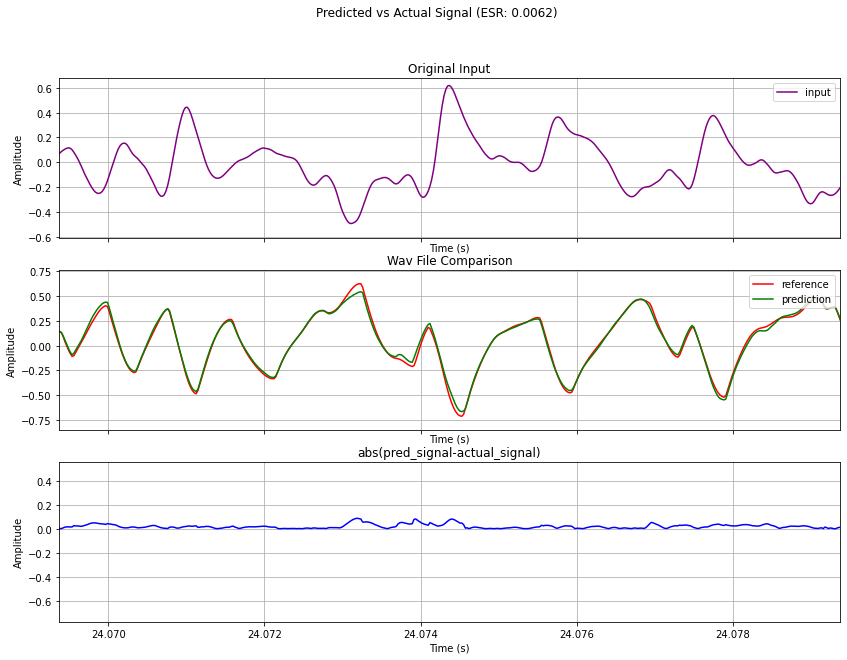

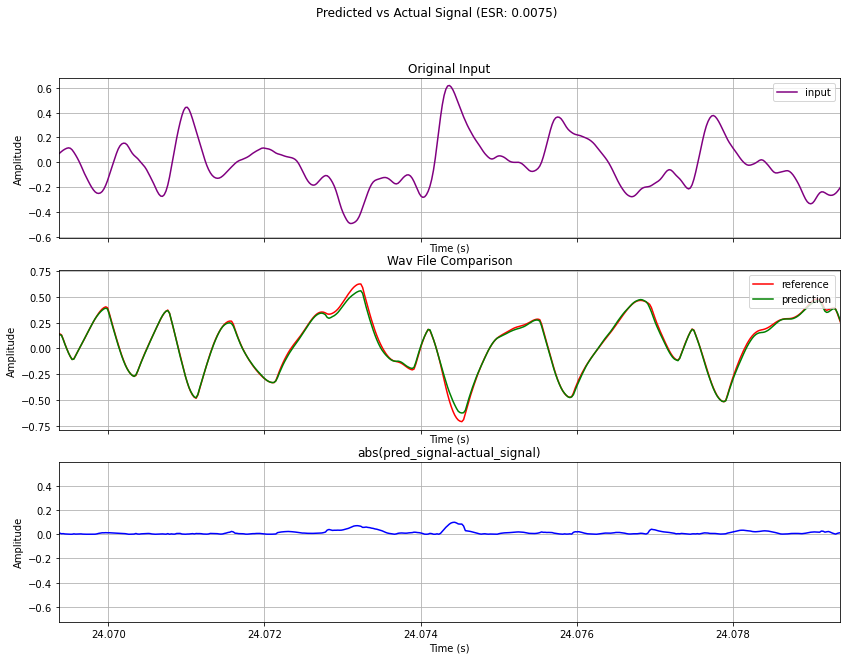

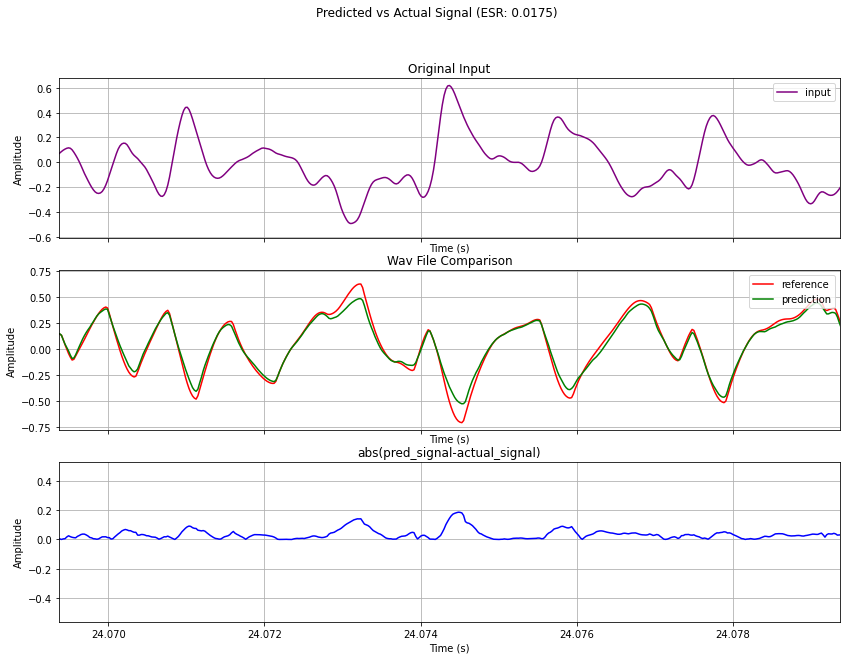

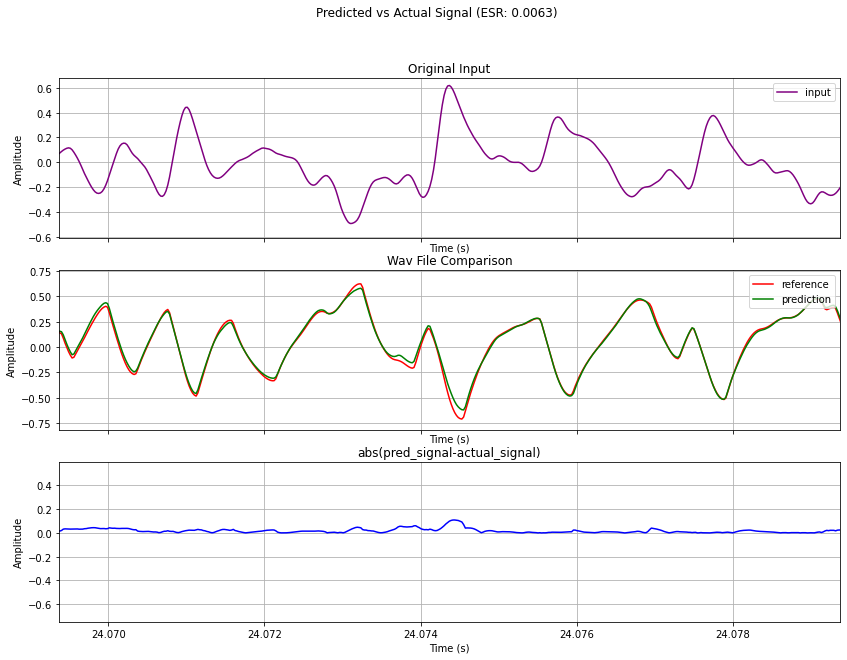

In [16]:
for model_path in model_paths:
    evaluate.evaluate_model(model_path)

In [9]:
model_paths = []
act_mode_8bit = True #automatically load quantized qat model (qat_best_q) if true
sr = 44100

# 1 input channel
#model_paths.append("./logs/remote/2021.12.08-152558__resimple_ch12_d8p2_lr1e-3_dith0hi0_qearly_test/")

#BEST OF THE BESTS
#model_paths.append(".\\logs\\tests\\2021.12.16-164950__resimple_CH32_ch24_d8p2_bs64_dithtri2.0o2hi17000_pre0.0_qearly_preproc0.90")
#model_paths.append("./logs/tests/2021.12.17-050902__resimple_CH32_ch24_d8p2_bs64_dithtri2.0o2hi15000_pre0.0preproc_0.90_qearly_pre/")

#model_paths.append("./logs/tests/2021.12.17-194844__resimple_2CH32_ch24_d8p2_bs128_dithtri2.0o2hi17000_pre0.0preproc_0.90_qearly_pre/")

log_folder = "\\\\?\\C:\\Users\\david\\Projects\\ai8x-training\\logs"
#model_paths.append(log_folder+"\\tests\\loss\\2021.12.18-112553__resimple_2CH32_ch24_d8p2_bs128_dithtri2.0o2hi17000_reg0.5pre0.0preproc_0.90_qearly_pre\\")

name = "2021.12.23-191347__resimple_AMPCAB1_CH32_ch24_d8p2_bs64_dithtri2.0o2hi17000_reg1e-4pre0.00preproc_0.95_qearly"
model_paths.append(log_folder+"\\tests\\generated\\"+name)

In [10]:
n_samples = None
model_path = model_paths[0]
y_pred_qat,dataset_inf,ckpt_inf,args = evaluate.predict_test_set(model_paths[0],act_mode_8bit,n_samples,sr)
y_test = dataset_inf["y_test"]

num hidden channels 24
model ai85simplewavenet
dataset PEDALNET_AMPCAB1_CH32
dl 8   p 2   r 1   k 3
Dither std: 2.0 hicutoff: 17000
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Configuring device: MAX78000, simulate=True.
{'start_epoch': 100, 'weight_bits': 8}
Model loaded correctly
dither pdf: triangular dither std: 2.0 dither order: 2 dither hicutoff: 17000
Configuring device: MAX78000, simulate=True.


In [11]:
(y_test_filt,y_pred_qat_filt) = evaluate.de_emphasize(y_pred_qat,dataset_inf,args)
scores_dict = evaluate.get_scores(y_test,y_test_filt,y_pred_qat,y_pred_qat_filt,ckpt_inf,args,dataset_inf['sampling_rate'])

In [12]:
print("---CHKPT INFO---")
print("Epoch QAT:",scores_dict['epoch_qat'])

decimals = 5
print("\n---PRE-FILTERED SIGNAL PERFORMANCE---")
print("Error to signal, with pre-filter used in training")
print("  QAT   :",np.around(scores_dict['ESR_train'],decimals))

print("\n---DE-FILTERED SIGNAL PERFORMANCE---")
print("Error to signal, with pre-filter")
print("  QAT   :",np.around(scores_dict['ESR_prefilt'],decimals))

print("Error to signal, no pre-filter")
print("  QAT   :",np.around(scores_dict['ESR_nofilt'],decimals))

print("Error to signal, with A-Weighting pre-filter")
print("  QAT   :",np.around(scores_dict['ESR_aweight'],decimals))

print("Error to signal, with lowpassed A-Weighting pre-filter")
print("  QAT   :",np.around(scores_dict['ESR_laweight'],decimals))

---CHKPT INFO---
Epoch QAT: 1635

---PRE-FILTERED SIGNAL PERFORMANCE---
Error to signal, with pre-filter used in training
  QAT   : 0.04422

---DE-FILTERED SIGNAL PERFORMANCE---
Error to signal, with pre-filter
  QAT   : 0.04422
Error to signal, no pre-filter
  QAT   : 0.03495
Error to signal, with A-Weighting pre-filter
  QAT   : 0.03121
Error to signal, with lowpassed A-Weighting pre-filter
  QAT   : 0.03107


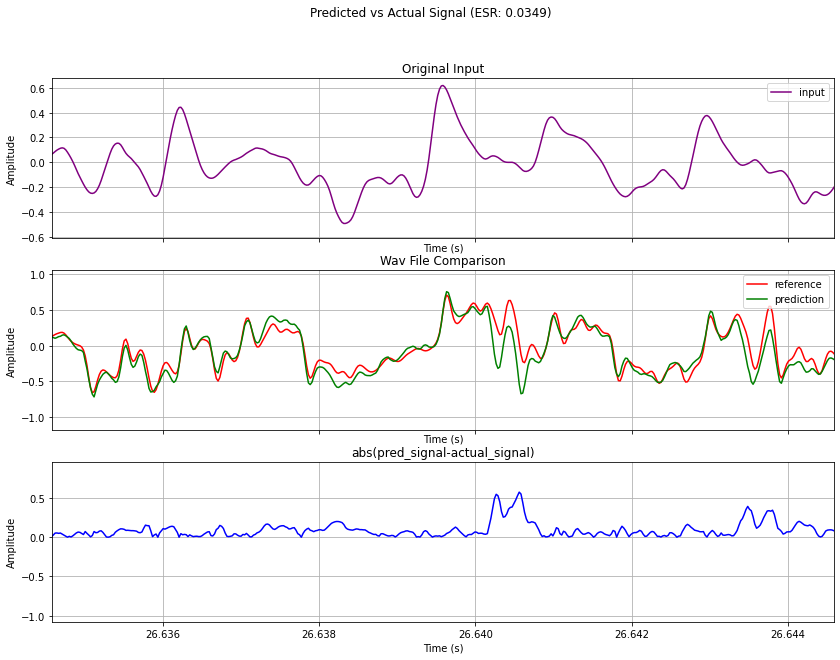

In [13]:
y_test_filt_flat = y_test_filt.flatten()
y_pred_qat_filt_flat = y_pred_qat_filt.flatten()
x_test_orig = dataset_inf['x_test_orig'].flatten()
sr = dataset_inf['sampling_rate']


Time = np.linspace(0, len(y_test_filt_flat) / sr, num=len(y_test_filt_flat))
fig, (ax3, ax1, ax2) = plt.subplots(3, sharex=True, figsize=(14, 10))
fig.suptitle("Predicted vs Actual Signal")
ax1.plot(Time, y_test_filt_flat, label="reference", color="red")

Time2 = np.linspace(0, len(y_pred_qat_filt_flat) / sr, num=len(y_pred_qat_filt_flat))
ax1.plot(Time2, y_pred_qat_filt_flat, label="prediction", color="green")
ax1.legend(loc="upper right")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Wav File Comparison")
ax1.grid("on")


fig.suptitle("Predicted vs Actual Signal (ESR: " + str(round(scores_dict['ESR_nofilt'], 4)) + ")")
# Plot signal difference
signal_diff = y_test_filt_flat - y_pred_qat_filt_flat
ax2.plot(Time2, np.abs(signal_diff), label="signal diff", color="blue")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")
ax2.set_title("abs(pred_signal-actual_signal)")
ax2.grid("on")


# Plot the original signal
Time3 = np.linspace(0, len(x_test_orig) / sr, num=len(x_test_orig))
ax3.plot(Time3, x_test_orig, label="input", color="purple")
ax3.legend(loc="upper right")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Amplitude")
ax3.set_title("Original Input")
ax3.grid("on")

plt.savefig(model_path + "\signal_comparison_esr_" + str(round(scores_dict['ESR_nofilt'], 4)) + ".png",facecolor="white", bbox_inches="tight")

# Create a zoomed in plot of 0.01 seconds centered at the max input signal value
sig_temp = x_test_orig.tolist()
plt.axis(
    [
        Time3[sig_temp.index((max(sig_temp)))] - 0.005,
        Time3[sig_temp.index((max(sig_temp)))] + 0.005,
        min(y_pred_qat_filt_flat),
        max(y_pred_qat_filt_flat),
    ]
)

# Save the plot
plt.savefig(model_path + "\detail_signal_comparison_esr_" + str(round(scores_dict['ESR_nofilt'], 4)) + ".png",facecolor="white", edgecolor='none', bbox_inches="tight")

In [14]:
decimals = 5
with open(model_path+'\\score.txt', 'w') as f:
        f.write('Best epoch:   ' + str(scores_dict['epoch_qat']) + '\n')
        f.write('ESR_train:    ' + str(round(scores_dict['ESR_train'], decimals)) + '\n')
        f.write('ESR_prefilt:  ' + str(round(scores_dict['ESR_prefilt'], decimals)) + '\n')
        f.write('ESR_nofilt:   ' + str(round(scores_dict['ESR_nofilt'], decimals)) + '\n')
        f.write('ESR_aweight:  ' + str(round(scores_dict['ESR_aweight'], decimals)) + '\n')
        f.write('ESR_laweight: ' + str(round(scores_dict['ESR_laweight'], decimals)) + '\n')
#print('\n')
print('Best epoch:   ' + str(scores_dict['epoch_qat']))
print('ESR_train:    ' + str(round(scores_dict['ESR_train'], decimals)))
print('ESR_prefilt:  ' + str(round(scores_dict['ESR_prefilt'], decimals)))
print('ESR_nofilt:   ' + str(round(scores_dict['ESR_nofilt'], decimals)))
print('ESR_aweight:  ' + str(round(scores_dict['ESR_aweight'], decimals)))
print('ESR_laweight: ' + str(round(scores_dict['ESR_laweight'], decimals)))
#print('\n')

Best epoch:   1635
ESR_train:    0.04422
ESR_prefilt:  0.04422
ESR_nofilt:   0.03495
ESR_aweight:  0.03121
ESR_laweight: 0.03107


In [15]:
json.dump( scores_dict, open(model_path+"\\score.json", 'w' ) )
json.load(open(model_path+"\\score.json", 'r' ))

{'epoch_qat': 1635,
 'sampling_rate': 44100,
 'predicted_samples': 1605240,
 'ESR_train': 0.04422358423471451,
 'ESR_prefilt': 0.04422357533573633,
 'ESR_nofilt': 0.034947766888124704,
 'ESR_aweight': 0.031214428361352266,
 'ESR_laweight': 0.031069949775693263}

In [16]:
from scipy.io import wavfile
save_samples = 10*sr
wavfile.write(model_path+"\\test.wav", sr, y_pred_qat_filt.flatten()[:save_samples].astype(np.float32))

In [17]:
ipd.Audio(y_pred_qat_filt.flatten(),rate=sr) 

In [18]:
ipd.Audio(y_test_filt.flatten(),rate=sr) 

In [19]:
index = 0
y_pred_qat_list =[y_pred_qat] 
dataset_list = [dataset_inf]

In [20]:
ipd.Audio(y_pred_list[index].flatten(),rate=sr) 

NameError: name 'y_pred_list' is not defined

In [ ]:
ipd.Audio(y_pred_filt.flatten(),rate=sr) 

In [ ]:
ipd.Audio(y_pred_qat_list[index].flatten(),rate=sr) 

In [ ]:
ipd.Audio(y_pred_qat_filt.flatten(),rate=sr) 

In [ ]:
ipd.Audio(y_test.flatten(),rate=sr) 

In [ ]:
ipd.Audio(y_test_filt.flatten(),rate=sr) 

In [ ]:
data = pickle.load(open("data/AUDIO/data.pickle", "rb"))
y_test_orig = data["y_test"]
ipd.Audio(y_test_orig.flatten(),rate=sr) 

In [ ]:
ipd.Audio(x_test[:,8,:].flatten(),rate=sr) 

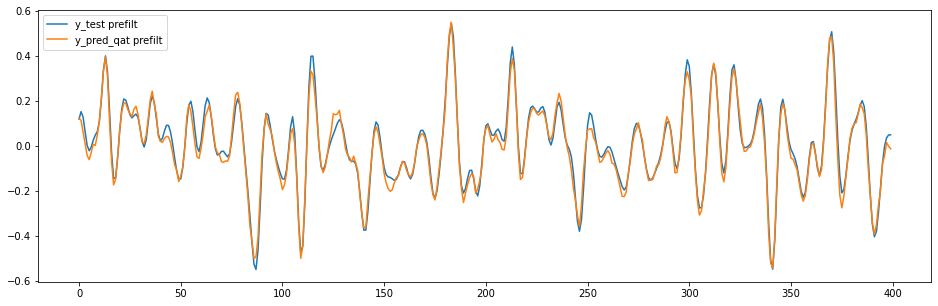

In [22]:
#detail
lenght = 400
sample=200#90 #50
#sample 200 is all zeros for dataset 2
plt.figure(figsize=(16,5))
plt.plot(y_test[sample,0,:lenght],label="y_test prefilt")
#plt.plot(y_pred_filt[sample,0,:lenght])
#plt.plot(y_pred_list[index][sample,0,:lenght])
plt.plot(y_pred_qat_list[index][sample,0,:lenght],label="y_pred_qat prefilt")
plt.legend()

#plt.plot(y_pred_qat_filt[sample,0,:lenght])

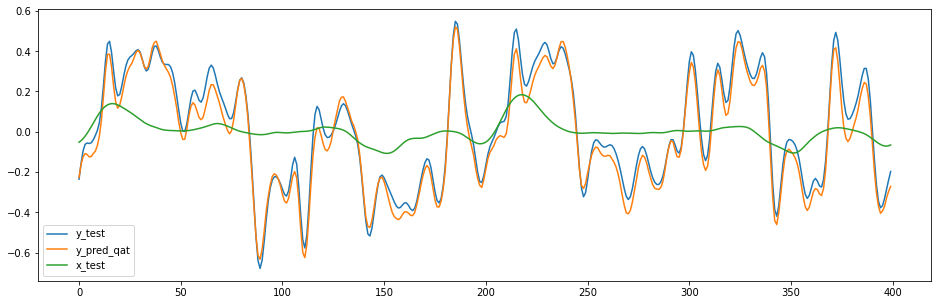

In [23]:
lenght = 400
sample=200#90 #50
#sample 200 is all zeros for dataset 2
plt.figure(figsize=(16,5))
plt.plot(y_test_filt[sample,0,:lenght],label="y_test")

plt.plot(y_pred_qat_filt[sample,0,:lenght],label="y_pred_qat")

plt.plot(dataset_list[index]['x_test_orig'][sample,0,:lenght],label="x_test")
#plt.plot(dataset_list[index]['y_test_orig'][sample,0,:lenght],label="y_test_orig")
plt.legend()

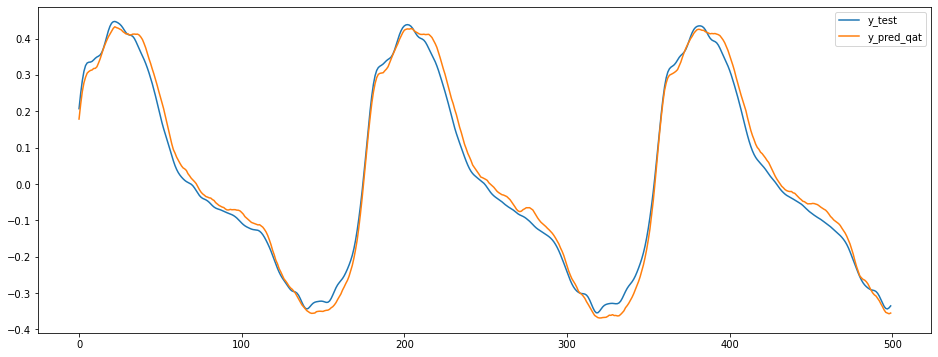

In [118]:
#detail FILTERED
lenght = 500
sample=60
plt.figure(figsize=(16,6))
plt.plot(y_test_filt[sample,0,:lenght],label="y_test")
#plt.plot(y_pred_filt[sample,0,:lenght])
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_qat_filt[sample,0,:lenght],label="y_pred_qat")
#plt.plot(y_pred_qat_filt[sample,0,:lenght])
plt.legend()

In [94]:
#LOAD original PEDALNET MODEL
from model_gated import PedalNet
#pedalnet_chekpoint = "./logs/model_gated_dl10_r1_dpow2_ch12_bs128_ep1500/model_gated_dl10_r1_dpow2_ch12_bs128_ep1500.ckpt"
pedalnet_chekpoint = "./logs/model_gated_dl10r1dpow2_ch32_bs128_ep2000e-3_lr3e-3_orig/model_gated_dl10r1dpow2_ch32_bs128_ep2000e-3_lr3e-3_orig.ckpt"
pedalnet_model = PedalNet.load_from_checkpoint(pedalnet_chekpoint)
pedalnet_model.eval()

#load data
data = pickle.load(open("data/AUDIO/data.pickle", "rb"))

x_test_orig = data["x_test"] #/data["x_test"].max()
y_test_orig = data["y_test"] #/data["y_test"].max()

#normalization
x_complete = np.concatenate([data["x_train"],data["x_valid"],data["x_test"]])
y_complete = np.concatenate([data["y_train"],data["y_valid"],data["y_test"]])

#PEDALNET inference
x_test_t = x_test_orig[:N_SAMPLES]
prev_sample = np.concatenate((np.zeros_like(x_test_t[0:1]), x_test_t[:-1]), axis=0)
pad_x_test = np.concatenate((prev_sample, x_test_t), axis=2)


y_pred = []
for x in np.array_split(pad_x_test, 10):
    y_pred.append(pedalnet_model(torch.from_numpy(x)).detach().numpy())

y_pred = np.concatenate(y_pred)
y_pred = y_pred[:, :, -x_test.shape[2] :]

#plt.plot(y_pred.flatten()[:200]/y_complete.max())
#plt.plot(y_test.flatten()[:200])
y_pred = y_pred/y_complete.max()
y_test_orig = y_test_orig/y_complete.max()

y_pred_list.append(y_pred)

NameError: name 'N_SAMPLES' is not defined

### original gated activation

In [ ]:
index = -1

In [ ]:
print("\n---DE-FILTERED SIGNAL PERFORMANCE---")
decimals = 4
print("Error to signal, with pre-filter")
pre_filter_coeff=0.95
ESR_prefilt = error_to_signal(torch.tensor(y_test_orig).reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),pre_filter_coeff).mean().numpy()
print("  ORIG   :",np.around(ESR_prefilt,decimals))

print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
ESR_nofilt = error_to_signal(torch.tensor(y_test_orig).reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),pre_filter_coeff).mean().numpy()
print("  ORIG   :",np.around(ESR_nofilt,decimals))

print("Error to signal, with A-Weighting pre-filter")
ESR_aweight = error_to_signal_aweight(y_test_orig.reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),sr).mean().numpy()
print("  ORIG   :",np.around(ESR_aweight,decimals))

print("Error to signal, with lowpassed A-Weighting pre-filter")
ESR_laweight = error_to_signal_lowpass_aweight(y_test_orig.reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),sr).mean().numpy()
print("  ORIG   :",np.around(ESR_laweight,decimals))

In [ ]:
print("Error to signal, with pre-filter")
pre_filter_coeff=0.95
print("Float:",error_to_signal(torch.tensor(y_test_orig).reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),pre_filter_coeff).mean())
#print("Float:",error_to_signal(torch.tensor(y_test_orig),torch.tensor(y_pred_list[index]),pre_filter_coeff).mean())
print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
print("Float:",error_to_signal(torch.tensor(y_test_orig).reshape(1,1,-1),torch.tensor(y_pred_list[index]).reshape(1,1,-1),0).mean().numpy())
#print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),0).mean())

In [ ]:
#detail
lenght = 400
sample=103
plt.figure(figsize=(16,8))
plt.plot(y_test_orig[sample,0,:lenght])
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_list[index][sample,0,:lenght])
plt.plot(y_pred_qat_filt[sample,0,:lenght])

In [ ]:
y_pred_err =  y_pred_list[index] - y_test
lenght = 2000
sample=40
plt.figure(figsize=(16,4))
plt.plot(y_pred_err[sample,0,:lenght])

In [ ]:
ipd.Audio(y_pred_err.flatten(),rate=sr)

### 12 input channels + dithering

In [ ]:
#low pass filtered output
cutoff=11000
order = 1
y_pred_qat_filt = y_pred_qat_list[index].flatten()

y_pred_qat_filt = butter_lowpass_filter(y_pred_qat_filt,cutoff,sr,order)

#smoothing
#smooth = 2
#kernel = np.ones(smooth) / smooth
#y_pred_qat_filt = np.convolve(y_pred_qat_filt.flatten(),kernel,mode="same")
y_pred_qat_filt = y_pred_qat_filt.reshape(y_pred_qat_list[index].shape)

In [ ]:
print("Error to signal, with pre-filter")
pre_filter_coeff=0.95
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),pre_filter_coeff).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),pre_filter_coeff).mean())
print("QAT_filt:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_filt),pre_filter_coeff).mean())
print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),0).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),0).mean())
print("QAT_filt:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_filt),0).mean())

In [ ]:
ipd.Audio(y_pred_qat_filt.flatten(),rate=sr)

In [ ]:
index = 0

In [ ]:
print("Error to signal, with pre-filter")
pre_filter_coeff=0.95
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),pre_filter_coeff).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),pre_filter_coeff).mean())
print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),0).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),0).mean())

In [ ]:
ipd.Audio(y_pred_list[index].flatten(),rate=sr)

In [ ]:
ipd.Audio(y_pred_qat_list[index].flatten(),rate=sr)

In [ ]:
ipd.Audio(np.concatenate(y_test.squeeze()),rate=sr)

In [ ]:
#detail
lenght = 100
sample=40
plt.figure(figsize=(16,5))
plt.plot(y_test[sample,0,:lenght])
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_list[index][sample,0,:lenght])
plt.plot(y_pred_qat_list[index][sample,0,:lenght])
#plt.plot(y_pred_qat_filt[sample,0,:lenght])

In [ ]:
#ERRORS
y_pred_err =  y_pred_list[index] - y_test
y_pred_qat_err =  y_pred_qat_list[index] - y_test

lenght = 2000
sample=40
plt.figure(figsize=(16,4))
#plt.plot(y_pred_filt[sample,0,:lenght])
#plt.plot(y_pred_list[index][sample,0,:lenght])
plt.plot(y_pred_err[sample,0,:lenght])
plt.plot(y_pred_qat_err[sample,0,:lenght])

In [ ]:
ipd.Audio(y_pred_err.flatten(),rate=sr)

In [ ]:
ipd.Audio(y_pred_qat_err.flatten(),rate=sr)

### 1 input channel

In [ ]:
index = 0

In [ ]:
print("Error to signal, with pre-filter")
pre_filter_coeff=0.95
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),pre_filter_coeff).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),pre_filter_coeff).mean())
print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),0).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),0).mean())

In [ ]:
ipd.Audio(np.concatenate(y_pred_list[index].squeeze()),rate=sr)

In [ ]:
ipd.Audio(np.concatenate(y_pred_qat_list[index].squeeze()),rate=sr)

In [ ]:
#detail
lenght = 100
sample=10
plt.figure(figsize=(16,5))
plt.plot(y_test[sample,0,:lenght])
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_list[index][sample,0,:lenght])
plt.plot(y_pred_qat_list[index][sample,0,:lenght])
#plt.plot(y_pred_qat_filt[sample,0,:lenght])

### Comparision 12ch vs 1ch

In [ ]:
#detail
#lenght = 500
samples=400#00
plt.figure(figsize=(14,10))

plt.subplot(3,1,1)
plt.title("Input")
#plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.plot(x_test[:samples,0,:].flatten(),label="Reference")
plt.ylim(-1,1)

plt.subplot(3,1,2)
plt.title("Output comparision")
#plt.xlabel("Samples")
plt.ylabel("Amplitude")
#plt.ylim(-1,1)
plt.plot(y_test[:samples,0,:].flatten(),label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_list[2][:samples,0,:].flatten(),label="Original",alpha=0.9)
plt.plot(y_pred_qat_list[0][:samples,0,:].flatten(),label="Model1",alpha=0.9)
plt.plot(y_pred_qat_list[1][:samples,0,:].flatten(),label="Model2",alpha=0.7)
plt.legend()


plt.subplot(3,1,3)
plt.title("Abs errors")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
#plt.ylim(-1,1)
#plt.plot(y_test[:samples,0,:].flatten(),label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(np.abs(y_pred_qat_list[0][:samples,0,:].flatten()-y_test[:samples,0,:].flatten()),label="Model1",alpha=0.9)
plt.plot(np.abs(y_pred_list[2][:samples,0,:].flatten()-y_test[:samples,0,:].flatten()),label="Original",alpha=0.9)
plt.plot(np.abs(y_pred_qat_list[1][:samples,0,:].flatten()-y_test[:samples,0,:].flatten()),label="Model2",alpha=0.9)
plt.legend()


In [ ]:
#### detail
lenght = 600
sample=40
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)

plt.grid("on")
plt.title("Signal comparision")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.plot(y_test[sample,0,:lenght],label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_qat_list[1][sample,0,:lenght],label="Model2")
plt.plot(y_pred_qat_list[0][sample,0,:lenght],label="Model1")
plt.legend()

plt.subplot(2,1,2)

plt.grid("on")
plt.title("Error comparision")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

#plt.plot(y_test[sample,0,:lenght],label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot([0])
plt.plot(np.abs(y_pred_qat_list[1][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model2")
plt.plot(np.abs(y_pred_qat_list[0][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model1")
plt.hlines(0,0,lenght,color="k",linestyles='solid',linewidth=0.5,zorder=2)
plt.legend()


In [ ]:
#### detail
lenght = 600
sample=71
#sample=40 30
plt.figure(figsize=(14,5))

plt.grid("on")
plt.title("Signal comparision")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.plot(y_test[sample,0,:lenght],"--",label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot(y_pred_list[2][sample,0,:lenght],label="Original")
plt.plot(y_pred_qat_list[1][sample,0,:lenght],label="Model2")
plt.plot(y_pred_qat_list[0][sample,0,:lenght],label="Model1")
plt.legend()

In [ ]:
#detail err
lenght = 600
sample= 71 #40
plt.figure(figsize=(14,3))
plt.grid("on")
plt.title("Error comparision")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

#plt.plot(y_test[sample,0,:lenght],label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])
plt.plot([0])
plt.plot(np.abs(y_pred_list[2][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Original")
plt.plot(np.abs(y_pred_qat_list[1][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model2")
plt.plot(np.abs(y_pred_qat_list[0][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model1")
#plt.hlines(0,0,lenght,color="k",linestyles='solid',linewidth=0.5,zorder=2)
plt.legend()

### 1 input channel + dithering (only in evaluation)

In [ ]:
# compute loss
args.pre_filter_coeff=0.95
criterion = model.get_loss_criterion(args)
criterion(torch.tensor(y_pred_list[index]),torch.tensor(y_test))

In [ ]:
print("Error to signal, no pre-filter")
pre_filter_coeff=0.00
print("Float:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_list[index]),0).mean())
print("QAT:",error_to_signal(torch.tensor(y_test),torch.tensor(y_pred_qat_list[index]),0).mean())

In [ ]:
ipd.Audio(np.concatenate(y_pred.squeeze()),rate=sr)

In [ ]:
ipd.Audio(np.concatenate(y_pred_qat.squeeze()),rate=sr)

## PSD analysis

In [54]:
y_pred = []
for x in np.array_split(pad_x_test, 10):
    y_pred.append(model(torch.from_numpy(x)).detach().numpy())
y_pred = np.concatenate(y_pred)
y_pred = y_pred[:, :, -x_test.shape[2] :]
y_pred_f = np.concatenate(y_pred.squeeze())
y_test_f = y_test.flatten()

NameError: name 'pad_x_test' is not defined

In [55]:
sr = 44100
l = sr*10
f = 440
t = np.linspace(0,l/sr,l)
t = t[:y_test_f.size]
sin = np.sin(2*np.pi*f*t)

NameError: name 'y_test_f' is not defined

In [56]:
#FFT

def compute_psd(y,sr,smooth=1):
    kernel = np.ones(smooth) / smooth
    n_freqs = len(y)//2
    psd  = np.abs(np.fft.fft(y))

    r = 44100
    n = psd.size
    timestep = 1/sr
    freq = np.fft.fftfreq(n, d=timestep)
    psd = np.convolve(psd,kernel,mode="same")
    return psd[:n_freqs],freq[:n_freqs]
    
#y_pred_psd,freq = compute_psd(y_pred_f,sr,1)
#n_freqs = 10000000
#kernel = np.ones(100) / 100
#plt.plot(freq,y_pred_psd)
#plt.plot(freq[:n_freqs],np.convolve(y_pred_psd,kernel,mode='same')[:n_freqs])
#plt.ylim(0,10)

In [57]:
def plt_psd(y,sr,smooth=1,scaling='log'):

    y_psd,freq = compute_psd(y,sr,smooth)

    plt.figure(figsize=(10,4))
    plt.yscale(scaling)
    plt.xscale(scaling)
    plt.plot(freq,y_psd)
#plt_psd(y_pred_f,sr)

In [69]:
#plot psd differences
n_samples = 356

freq_a = 100#800*10
freq_b = 200000*n_samples//100 #830*10

x_scale = 'log' #log or linear
y_scale = 'log'

smooth_psd = 5
smooth_diffs = 1

y_pred_f = y_pred_qat_filt.flatten()
y_pred_f = evaluate.lowpass_filter()
#y_pred_f = pre_emphasis_filter(torch.tensor(x_train.reshape(1,1,-1)),filter_coeff).numpy().reshape(x_train.shape)
y_test_f = y_test_filt.flatten()

y_pred_psd,freq = compute_psd(y_pred_f,sr,smooth_psd)
y_test_psd,freq = compute_psd(y_test_f,sr,smooth_psd)

y_diff_abs = y_test_psd-y_pred_psd
y_diff_rel = (y_test_psd-y_pred_psd)/np.maximum(np.abs(y_test_psd),1)

#smood diffs
kernel = np.ones(smooth_diffs) / smooth_diffs
y_diff_abs = np.convolve(y_diff_abs,kernel,mode="same")
y_diff_rel = np.convolve(y_diff_rel,kernel,mode="same")

plt.figure(figsize=(16,12))
plt.subplot(3,1,1)
plt.title("psd")
plt.yscale(y_scale)
plt.xscale(x_scale)
plt.hlines(0,freq[freq_a],freq[freq_b],color="grey",linestyles='solid',linewidth=2)
plt.plot(freq[freq_a:freq_b],y_test_psd[freq_a:freq_b],alpha=0.99,label='y_target')
plt.plot(freq[freq_a:freq_b],y_pred_psd[freq_a:freq_b],alpha=0.75,label='y_pred')
plt.legend()
#plt.plot(freq[freq_a:freq_b],y_diff_abs[freq_a:freq_b]-600)
#plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b]*100-1000)
#plt.ylim(-0,1500)

plt.subplot(3,1,2)
plt.title("psd diff")
plt.yscale(y_scale)
plt.xscale(x_scale)
plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=1)
#plt.plot(freq[freq_a:freq_b],np.abs(y_diff_abs[freq_a:freq_b]),zorder=1)
y_diff_pos = np.maximum(y_diff_abs[freq_a:freq_b],0)
y_diff_pos[y_diff_pos==0] = np.nan
y_diff_neg = np.minimum(y_diff_abs[freq_a:freq_b],0)
y_diff_neg[y_diff_neg==0] = np.nan
plt.plot(freq[freq_a:freq_b],y_diff_pos,color="g",zorder=1,label='positive diff')
plt.plot(freq[freq_a:freq_b],np.abs(y_diff_neg),color="r",alpha=0.75,zorder=1,label='negative diff')
plt.legend()
#plt.ylim(-200,240)

# interesting plot: error for each freq in PERCENTAGE of the amount of that freq in y target!
plt.subplot(3,1,3)
plt.title("psd diff relative")
plt.yscale("linear")
plt.xscale(x_scale)
plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=2)
plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b],zorder=1)
plt.ylim(-3,1.5)

AttributeError: module 'evaluate' has no attribute 'lowpass_filter'

In [ ]:
y_pred_l = [y_pred_qat_list[0],y_pred_qat_list[1],y_pred_list[2]]
names = ["Model1","Model2","Original"]

In [60]:
#plot psd differences
freq_a = 100#800*10
freq_b = 200000*n_samples//100 #830*10

x_scale = 'log' #log or linear
y_scale = 'log'


smooth_psd = 3
smooth_diffs = 1

index = 2
y_pred_psd,freq = compute_psd(y_pred_l[index].flatten(),sr,smooth_psd)
y_test_psd,freq = compute_psd(y_test.flatten(),sr,smooth_psd)

#y_err_psd,freq = compute_psd((y_test.flatten()-y_pred_l[index].flatten()),sr,smooth_psd)

y_diff_abs = y_test_psd-y_pred_psd
y_diff_rel = np.abs(y_test_psd-y_pred_psd)/np.maximum(np.abs(y_test_psd),1)

#smood diffs
kernel = np.ones(smooth_diffs) / smooth_diffs
y_diff_abs = np.convolve(y_diff_abs,kernel,mode="same")
y_diff_rel = np.convolve(y_diff_rel,kernel,mode="same")

plt.figure(figsize=(7,12))
plt.subplot(3,1,1)
plt.grid("on")
plt.title("PSD of "+names[index])
#plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.yscale(y_scale)
plt.xscale(x_scale)
plt.hlines(0,freq[freq_a],freq[freq_b],color="grey",linestyles='solid',linewidth=2)
plt.plot(freq[freq_a:freq_b],y_test_psd[freq_a:freq_b],alpha=0.98,label='Target PSD')
plt.plot(freq[freq_a:freq_b],y_pred_psd[freq_a:freq_b],alpha=0.75,label=names[index]+" PSD")
plt.legend()
#plt.plot(freq[freq_a:freq_b],y_diff_abs[freq_a:freq_b]-600)
#plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b]*100-1000)
#plt.ylim(-0,1500)

plt.subplot(3,1,2)
plt.grid("on")
plt.title("PSD difference (target_PSD -"+names[index]+"_PSD)")
#plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.yscale(y_scale)
plt.xscale(x_scale)
plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=1)
#plt.plot(freq[freq_a:freq_b],np.abs(y_diff_abs[freq_a:freq_b]),zorder=1)
y_diff_pos = np.maximum(y_diff_abs[freq_a:freq_b],0)
y_diff_pos[y_diff_pos==0] = np.nan
y_diff_neg = np.minimum(y_diff_abs[freq_a:freq_b],0)
y_diff_neg[y_diff_neg==0] = np.nan
plt.plot(freq[freq_a:freq_b],y_diff_pos,color="g",zorder=1,label='positive diff')
plt.plot(freq[freq_a:freq_b],np.abs(y_diff_neg),color="r",alpha=0.75,zorder=1,label='negative diff')
plt.legend()
#plt.ylim(-200,240)

# interesting plot: error for each freq in PERCENTAGE of the amount of that freq in y target!
plt.subplot(3,1,3)
plt.grid("on")
#plt.title("PSD of error signals PSD(error)")
plt.title("PSD relative difference ("+names[index]+"_PSD vs target _PSD)")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.yscale("linear")
plt.xscale(x_scale)
#plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=2)
plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b],zorder=1)
#plt.plot(freq[freq_a:freq_b],y_err_psd[freq_a:freq_b],zorder=1)
plt.ylim(-0.1,7)

NameError: name 'y_pred_l' is not defined

In [61]:
#plot psd of ERRORS
freq_a = 100#800*10
freq_b = 200000*n_samples//100 #830*10

x_scale = 'log' #log or linear
y_scale = 'log'

smooth = 10

index = 0

y_err_psd_0,freq = compute_psd((y_test.flatten()-y_pred_l[0].flatten()),sr,smooth)
y_err_psd_1,freq = compute_psd((y_test.flatten()-y_pred_l[1].flatten()),sr,smooth)
y_err_psd_2,freq = compute_psd((y_test.flatten()-y_pred_l[2].flatten()),sr,smooth)

#smood diffs
kernel = np.ones(smooth_diffs) / smooth_diffs


plt.figure(figsize=(14,15))

plt.title("PSD of signals")
#plt.xlabel("Frequency")
plt.ylabel("PSD")
# interesting plot: error for each freq in PERCENTAGE of the amount of that freq in y target!
plt.subplot(3,1,3)
plt.grid("on")
plt.title("PSD of error signals error_PSD")
#plt.title("PSD relative difference (PSD error vs target PSD)")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.yscale("linear")
plt.xscale(x_scale)
#plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=2)
#plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b],zorder=1)
plt.plot(freq[freq_a:freq_b],y_err_psd_0[freq_a:freq_b],zorder=1,label="Model1")
plt.plot(freq[freq_a:freq_b],y_err_psd_1[freq_a:freq_b],zorder=1,label="Model2",alpha=0.8)
plt.plot(freq[freq_a:freq_b],y_err_psd_2[freq_a:freq_b],zorder=1,label="Original",alpha=0.8)
plt.legend()
plt.ylim(-100,2000)

NameError: name 'y_pred_l' is not defined

In [62]:
#plot psd of ERRORS
freq_a = 100#800*10
freq_b = 200000*n_samples//100 #830*10

x_scale = 'log' #log or linear
y_scale = 'log'

smooth = 10

index = 0

y_err_psd_0,freq = compute_psd((y_test.flatten()-y_pred_l[0].flatten()),sr,smooth)
y_err_psd_1,freq = compute_psd((y_test.flatten()-y_pred_l[1].flatten()),sr,smooth)
y_err_psd_2,freq = compute_psd((y_test.flatten()-y_pred_l[2].flatten()),sr,smooth)

#smood diffs
kernel = np.ones(smooth_diffs) / smooth_diffs


plt.figure(figsize=(14,15))

plt.title("PSD of signals")
#plt.xlabel("Frequency")
plt.ylabel("PSD")
# interesting plot: error for each freq in PERCENTAGE of the amount of that freq in y target!
plt.subplot(3,1,3)
plt.grid("on")
plt.title("PSD of error signals error_PSD")
#plt.title("PSD relative difference (PSD error vs target PSD)")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.yscale("linear")
plt.xscale(x_scale)
#plt.hlines(0,freq[freq_a],freq[freq_b],color="k",linestyles='solid',linewidth=0.5,zorder=2)
#plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b],zorder=1)
#plt.plot(freq[freq_a:freq_b],y_err_psd_0[freq_a:freq_b],zorder=1,label="Model1")
plt.plot(freq[freq_a:freq_b],y_err_psd_1[freq_a:freq_b],zorder=1,label="Model2",alpha=0.8)
plt.plot(freq[freq_a:freq_b],y_err_psd_2[freq_a:freq_b],zorder=0,label="Original",alpha=0.8)
plt.legend()
plt.ylim(-100,500)

NameError: name 'y_pred_l' is not defined

In [ ]:
y_pred_qat_err = y_pred_qat_list[1][sample,0,:lenght]-y_test[sample,0,:lenght]
y_pred_err = y_pred_list[2][sample,0,:lenght]-y_test[sample,0,:lenght]

cutoff_low = 100
cutoff_hi = 1000
order = 2

y_pred_qat_err = butter_bandpass_filter(y_pred_qat_err,cutoff_low,cutoff_hi,sr,order)
y_pred_err = butter_bandpass_filter(y_pred_err,cutoff_low,cutoff_hi,sr,order)

#y_pred_qat_err = butter_lowpass_filter(y_pred_qat_err,cutoff,sr,order)
#y_pred_err = butter_lowpass_filter(y_pred_err,cutoff,sr,order)


In [ ]:
#detail err
lenght = 600
sample= 71 #40
plt.figure(figsize=(14,3))
plt.grid("on")
plt.title("Error comparision")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

#plt.plot(y_test[sample,0,:lenght],label="Reference")
#plt.plot(y_pred_filt[sample,0,:lenght])

plt.plot([0])
#plt.plot(np.abs(y_pred_list[2][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Original")3
#plt.plot(np.abs(y_pred_qat_list[1][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model2")
plt.plot(np.abs(y_pred_err),label="Origianl_filt")
plt.plot(np.abs(y_pred_qat_err),label="Model_filt")
#plt.plot(np.abs(y_pred_qat_list[0][sample,0,:lenght]-y_test[sample,0,:lenght]),label="Model1")
#plt.hlines(0,0,lenght,color="k",linestyles='solid',linewidth=0.5,zorder=2)
plt.legend()

In [ ]:
plt.figure(figsize=(2,2))
plt.title("psd")
plt.plot(freq[freq_a:freq_b],y_test_psd[freq_a:freq_b])
plt.plot(freq[freq_a:freq_b],y_pred_psd[freq_a:freq_b])
plt.plot(freq[freq_a:freq_b],y_diff_abs[freq_a:freq_b]-200)
plt.plot(freq[freq_a:freq_b],y_diff_rel[freq_a:freq_b]*100-400)
plt.ylim(-1000,2000)

In [ ]:
plt.plot(y_test_f,zorder=1)
plt.plot(y_pred_f,zorder=2)
plt.hlines(y_pred_f.mean(),0,y_test_f.size,color="green",linestyles='dashed',zorder=3)
plt.hlines(y_test_f.mean(),0,y_pred_f.size,color="red",linestyles='dashed',zorder=4)

### Conclusions
1. mean of prediction NOT zero (bias I am looking at you) -> big err at 0 freq
2. the ABS err is mostly at LOW-MID frequencies -> try to REMOVE pre filter, or increase those freq in the error
    1. possible reason is because of RELU use -> automatically we get more higher order harmonics thus need to boos mid freqs
3. relative error (in %) is high between 12/15 Khz
4. relative error: low freq NEED to be bosted, high freq need to be made small

### Filtering test

In [ ]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='lowpass')
    return b, a

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    #high = highcut / nyq
    b, a = butter(order, [low], btype='highpass')
    return b, a

def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

# Plot the frequency response for a few different orders.
plt.figure(figsize=(4,2,))
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
#bandpass filter
lowcut = 1
highcut = 1000
order = 1

b, a = butter_bandpass(lowcut, highcut, sr, order=order)
w, h = freqz(b, a, worN=2000)
plt.figure(figsize=(4,2,))
plt.plot((sr * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
lowcut = 100
highcut = 9000
order = 4
y_pred_filt = butter_bandpass_filter(y_pred_f,lowcut, highcut, sr, order=order)
y_test_filt = butter_bandpass_filter(y_test_f,lowcut, highcut, sr, order=order)

In [ ]:
#plt_psd(y_pred_f,sr)
smooth=1
y_psd,freq = compute_psd(y_pred_f,sr,smooth)
y_pred_filt_psd,freq = compute_psd(y_pred_filt,sr,smooth)
y_test_filt_psd,freq = compute_psd(y_test_filt,sr,smooth)

scaling='log'
plt.figure(figsize=(16,4))
plt.yscale(scaling)
plt.xscale(scaling)
plt.plot(freq,y_psd)
plt.plot(freq,y_pred_filt_psd)
plt.plot(freq,y_test_filt_psd)

In [ ]:
#lowpass filter
highcut = 17000
order = 1
b, a = butter_lowpass(highcut, sr, order=order)
w, h = freqz(b, a, worN=2000)
plt.figure(figsize=(4,2,))
plt.plot((sr * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
#lowpass filter
highcut = 17000
order = 1
#b, a = butter_lowpass(highcut, sr, order=order)
wz = 1000
w1 = 10000
#b = [wz, 1.]
#a = [w1, 1.]

b = [1., 0.5]
a = [1., 0.01]

w, h = freqz(b, a, worN=2000)
plt.figure(figsize=(4,2,))
plt.plot((sr * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
def pre_emphasis_filter(x, coeff=0.95):
    return torch.cat((x[:, :, 0:1], x[:, :, 1:] - coeff * x[:, :, :-1]), dim=2)

In [ ]:
#lowpass filter
highcut = 10000
order = 2
b, a = butter_lowpass(highcut, sr, order=order)
w, h = freqz(b, a, worN=2000)
plt.figure(figsize=(4,2,))
plt.plot((sr * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
#TRY TO FILTER y PRED to make it similar to 
#slight low pass (1 order)
highcut = 5000
order = 5
y_pred_filt = butter_lowpass_filter(y_pred_f, highcut, sr, order=order)
y_test_filt = butter_lowpass_filter(y_test_f, highcut, sr, order=order)

In [ ]:
#y_pred_filt = pre_emphasis_filter(torch.Tensor(y_pred),coeff=.95).flatten()

In [ ]:
#plt_psd(y_pred_f,sr)
smooth=1
y_psd,freq = compute_psd(y_pred_f,sr,smooth)
y_pred_filt_psd,freq = compute_psd(y_pred_filt,sr,smooth)
y_test_f_psd,freq = compute_psd(y_test_f,sr,smooth)

scaling='log'
plt.figure(figsize=(10,4))
plt.yscale(scaling)
plt.xscale(scaling)

plt.plot(freq,y_psd)
plt.plot(freq,y_test_f_psd,alpha=0.8)
plt.plot(freq,y_pred_filt_psd,alpha=0.8)


In [ ]:
start_f = 0 #60000
ipd.Audio(y_pred_filt[start_f:],rate=sr)

In [ ]:
ipd.Audio(y_test_filt[start_f:],rate=sr)

In [ ]:
ipd.Audio(y_pred_f[start_f:],rate=sr)

In [ ]:
ipd.Audio(y_test_f[start_f:],rate=sr)

## DITHERING

Starting test with dithering

Roadmap
1. uniform dithering
2. highpassed dithering (noise shaping)
3. dithering in oversampled region

In [ ]:
# prepare and load test data
sr = 44100
n_samples = 100 #*sr

data = pickle.load(open("data/AUDIO/data.pickle", "rb"))
x_test = data["x_test"] #/data["x_test"].max()
y_test = data["y_test"] #/data["y_test"].max()

#normalization
x_complete = np.concatenate([data["x_train"],data["x_valid"],data["x_test"]])
y_complete = np.concatenate([data["y_train"],data["y_valid"],data["y_test"]])

x_test = x_test[:n_samples]
y_test = y_test[:n_samples]

x_test = x_test/x_complete.max()
y_test = y_test/y_complete.max()

x_test_f = x_test.flatten()

#quantization
#if not args.dataset=="PEDALNET_FLOAT":
#    x_test = (x_test*0.5*256.).round().clip(min=-128, max=127)/(128.)
#    y_test = (y_test*0.5*256.).round().clip(min=-128, max=127)/(128.)

def prepare_x(x_test):
    prev_sample = np.concatenate((np.zeros_like(x_test[0:1]), x_test[:-1]), axis=0)
    pad_x_test = np.concatenate((prev_sample, x_test), axis=2)
    return pad_x_test

#pad_x_test = pad_x_test[:n_samples,:,:]


In [ ]:
from scipy.signal import butter, lfilter
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='highpass')
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, [high], btype='lowpass')
    return b, a
def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def create_dithering_noise(shape,sr,std,lowcut,order=1,pdf="normal"):
    """Creates dithering noises of the given shape, to be added to  signal
    Args:
        shape: shape of the array
        sr: sampling rate
        std: in normal case, std deviation with respect to quant level, in triangualr case is max noise value
        lowcut: cutoff freq of low pass filter on dithering noise
        pdf: "triangular" or "normal"
    """
    # dithering noise (gaussian psd)
    #N = x_test_f.size #input (x lenght)
    q_step = (1./128)
    dither_std = std*q_step #lowest with still good results
    if pdf=="normal":
        dither_noise = np.random.randn(*shape)*dither_std
    elif pdf=="triangular":
        dither_noise = np.random.triangular(-dither_std,0,dither_std,shape)
    else:
        raise Exception("Invalid noise pdf",pdf) 
    #noise shaping / dither filtering
    #dither_noise_2 = butter_highpass_filter(dither_noise_2, lowcut, sr, order=order)
    dither_noise = butter_highpass_filter(dither_noise, lowcut, sr, order=order)
    return dither_noise.astype(np.float32)

In [ ]:
# dithering noise (gaussian psd)
N = x_test_f.size #input (x lenght)
q_step = (1./128)
dither_std = 1.0*q_step #lowest with still good results

dither_noise_1 = np.random.randn(N)*dither_std
#dither_noise_1 = np.random.triangular(-dither_std,0,dither_std,N) #*dither_std

dither_noise_2 = np.random.randn(N)*dither_std

#noise shaping / dither filtering
lowcut = 100 #14000 #15000
order = 1 #2
#dither_noise_2 = butter_highpass_filter(dither_noise_2, lowcut, sr, order=order)
dither_noise_1 = butter_highpass_filter(dither_noise_1, lowcut, sr, order=order)


dither_noise = dither_noise_1# + dither_noise_2

smooth = 1
dither_noise_psd,freq  = compute_psd(dither_noise,sr,smooth)


plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(dither_noise[:100])
plt.subplot(1,3,2)
hist = np.histogram(dither_noise,bins=20)
plt.plot(hist[1][:-1],hist[0])

plt.subplot(1,3,3)
plt.yscale('log')
plt.xscale('log')
plt.plot(freq,dither_noise_psd)

In [ ]:
dither_noise = create_dithering_noise(x_test_f.shape,sr,1,100,"triangular")

In [ ]:
# BEST PARAMETERS: ch12, std2, cutoff17000 order2 pdf=triangualr
ch=12
std = 2.00
cutoff = 17000
order = 2
pdf = "triangular"
x_test_multidither = []
for i in range(ch):
    x_dither = x_test_f +  create_dithering_noise(x_test_f.shape,sr,std,cutoff,order,pdf)
    x_dither_q = (x_dither*0.5*256.).round().clip(min=-128, max=127)/(128.)
    
    x_test_multidither.append(x_dither_q)
x_test_multidither = np.array(x_test_multidither)
print(x_test_multidither.shape)

In [ ]:
x_avg = x_test_multidither.mean(0)
ipd.Audio(x_avg,rate=sr)

In [ ]:
plt.plot(x_test_f-x_avg)

In [ ]:
x_avg_triangular
ipd.Audio(x_avg_triangular,rate=sr) 

In [ ]:
ipd.Audio(x_test_f,rate=sr)

In [ ]:
ipd.Audio(x_test_multidither[0],rate=sr)

In [ ]:
dither_noise_norm = dither_noise
ipd.Audio(dither_noise,rate=sr)

In [ ]:
# DITHERING/FILTERING
x_test_dither = x_test_f +  dither_noise
ipd.Audio(x_test_dither,rate=sr)

In [ ]:
highcut = 7000
order = 2
#x_test_dither = butter_lowpass_filter(x_test_dither, highcut, sr, order=order)
#x_test_filt_q = x_test_q

b, a = butter_lowpass(highcut, sr, order=order)
w, h = freqz(b, a, worN=2000)
#plt.figure(figsize=(4,2,))
#plt.plot((sr * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

In [ ]:
# Quantization

x_test_ditherq = (x_test_dither*0.5*256.).round().clip(min=-128, max=127)/(128.)
x_test_naiveq = (x_test_f*0.5*256.).round().clip(min=-128, max=127)/(128.)

x_qerror_dither = x_test_f-x_test_ditherq
x_qerror_naive = x_test_f-x_test_naiveq

In [ ]:
#plt_psd(y_pred_f,sr)
smooth=10
x_psd,freq = compute_psd(x_test_f,sr,smooth)
x_psd_ditherq,freq = compute_psd(x_test_ditherq,sr,smooth)
x_psd_naiveq,freq = compute_psd(x_test_naiveq,sr,smooth)

x_psd_qerror_dither,freq  = compute_psd(x_qerror_dither,sr,smooth)
x_psd_qerror_naive,freq  = compute_psd(x_qerror_naive,sr,smooth)

#y_pred_filt_psd,freq = compute_psd(y_pred_filt,sr,smooth)
#y_test_f_psd,freq = compute_psd(y_test_f,sr,smooth)

scaling='log'
plt.figure(figsize=(10,4))
plt.yscale(scaling)
plt.xscale(scaling)

plt.plot(freq,x_psd,alpha=0.2,label="x")

plt.plot(freq,x_psd_ditherq,alpha=0.8,label="x_ditherq")
plt.plot(freq,x_psd_qerror_dither,alpha=0.6,label="x_dither_err")

plt.plot(freq,x_psd_naiveq,alpha=0.6,label="x_naiveq")
plt.plot(freq,x_psd_qerror_naive,alpha=0.6,label="x_naive_err")

plt.legend()


#plt.plot(freq,y_test_f_psd)
#plt.plot(freq,y_pred_filt_psd)

In [ ]:
dither_noise[0]=1
ipd.Audio(dither_noise,rate=sr)

In [ ]:
ipd.Audio(x_test_f,rate=sr)

In [ ]:
ipd.Audio(x_test_ditherq,rate=sr)

In [ ]:
x_qerror_dither_norm = x_qerror_dither.copy()
x_qerror_dither_norm[0]=0.9
ipd.Audio(x_qerror_dither_norm,rate=sr)

In [ ]:
ipd.Audio(x_test_naiveq,rate=sr)

In [ ]:
x_qerror_naive_norm = x_qerror_naive.copy()
x_qerror_naive_norm[0]=0.5
ipd.Audio(x_qerror_naive_norm,rate=sr)

In [ ]:
sampl = 200
plt.figure(figsize=(13,6))
plt.plot(x_test_f[:sampl])
plt.plot(x_test_naiveq[:sampl])
#plt.plot(x_test_filt_q[:sampl])

plt.plot(x_qerror_naive[:sampl])

In [ ]:
sampl = 200
plt.figure(figsize=(13,6))
plt.plot(x_test_f[:sampl])
#plt.plot(x_test_dither[:sampl])
plt.plot(x_test_ditherq[:sampl])
plt.plot(x_qerror_dither[:sampl])

In [ ]:
def wavenet_predict(x,model):
    pad_x_test = prepare_x(x.reshape(x_test.shape)).astype(np.float32)
    y_pred = []
    for x in np.array_split(pad_x_test, 10):
        y_pred.append(model(torch.from_numpy(x)).detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_pred = y_pred[:, :, -x_test.shape[2] :]
    y_pred_f = np.concatenate(y_pred.squeeze())
    return y_pred_f
    

In [ ]:
#predict
y_pred_ditherq = wavenet_predict(x_test_ditherq,model)

In [ ]:
y_pred_naiveq = wavenet_predict(x_test_naiveq,model)

In [ ]:
ipd.Audio(y_pred_ditherq,rate=sr)

In [ ]:
ipd.Audio(y_pred_naiveq,rate=sr)

In [ ]:
ipd.Audio(y_test_f,rate=sr)

In [ ]:
#plt_psd(y_pred_f,sr)
smooth=10
x_psd,freq = compute_psd(x_test_f,sr,smooth)
x_psd_q,freq = compute_psd(x_test_q,sr,smooth)
x_psd_naiveq,freq = compute_psd(x_test_naiveq,sr,smooth)

#y_pred_filt_psd,freq = compute_psd(y_pred_filt,sr,smooth)
#y_test_f_psd,freq = compute_psd(y_test_f,sr,smooth)

scaling='log'
plt.figure(figsize=(10,4))
plt.yscale(scaling)
plt.xscale(scaling)

plt.plot(freq,x_psd,alpha=0.9)
plt.plot(freq,x_psd_q,alpha=0.8)

plt.plot(freq,x_psd_naiveq,alph§a=0.6)

#plt.plot(freq,y_test_f_psd)
#plt.plot(freq,y_pred_filt_psd)

#### Analysis Quantization

Without Dithering
1. quant noise is very harsh when input is quite... ma vaaa

With naive gaussian dithering


## FILTERING TEST

In [ ]:
#FILTERING TEST
y_pred_flat = np.concatenate(y_pred.squeeze().detach().numpy())

In [ ]:
y_pred_flat = y_pred_flat - y_pred_flat.mean()

In [ ]:
plt.plot(y_pred_flat)

In [ ]:
ipd.Audio(y_pred_flat,rate=sr)

In [ ]:
ipd.Audio(np.concatenate(x_test.squeeze()),rate=sr)

In [ ]:
ipd.Audio(np.concatenate(y_test.squeeze()),rate=sr)

In [ ]:
#quantize y test
x_test = (x_test*0.5*256.).round().clip(min=-128, max=127)/(128.)
y_test = (y_test*0.5*256.).round().clip(min=-128, max=127)/(128.)

In [ ]:
plt.plot(y_test[70,0,:1000])

In [ ]:
sample = 30
n_sampl = 500
plt.plot(y_pred[sample].squeeze().detach().numpy()[:n_sampl])
plt.plot(x_test[sample].squeeze()[-out_sample_size:-out_sample_size+n_sampl])
plt.plot(y_test[sample].squeeze()[:n_sampl])

In [ ]:
outputs = model(inputs)

In [ ]:
i = 250
plt.plot(inputs[i,:,-out_sample_size:].flatten().detach())
plt.plot(target[i].flatten().detach())
plt.plot(outputs[i].flatten().detach())

In [ ]:
### plt.plot(inputs[0:50].flatten().detach())
#plt.plot(outputs[0:50].flatten().detach())
plt.plot((target)[0:50].flatten().detach())
#plt.plot((target*0.5-0.3)[0:50].flatten().detach())

## OTHER SHIT

In [ ]:
#inp = torch.ones(1,1,4410)
#inp = ((torch.rand(1,1,4410)-0.5)*4.0).clamp(-2,2)
t = np.linspace(0,10,4410)
inp = torch.tensor(np.sin(t*100))*2
inp = inp.reshape(1,1,4410).float()

In [ ]:
model.input_layer.op.weight.data[:,0,:] = torch.tensor([0,0,1])
#model.input_layer.op.weight.data[1,0,:] = torch.tensor([0,0,-1])
model.input_layer.op.weight.data[:,1:,:] = torch.tensor([0,0,0])
model.input_layer.op.bias.data[:] = 0

for l in model.hidden:
    l.op.weight.data[:,0,:] = torch.tensor([0,0,1])
    l.op.weight.data[:,1:,:] = torch.tensor([0,0,0])
    l.op.bias.data[:] = 0
model.linear_mix.op.weight.data[:,:,0] = torch.tensor([10,0,0,0,0,0,0,0,0,0,0,0])

In [ ]:
out = model(inp)

In [ ]:
n = 10
plt.plot(inp[0,0,-out_sample_size:-out_sample_size+n].detach())
plt.plot(out[0,0,:n].detach())

In [ ]:
for module in model.modules():
    if isinstance(module, ai8x.FusedConv1dReLU):
        module.clamp = ai8x.Empty()
    

In [ ]:
model